In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from sympy.solvers import solve
import seaborn as sns
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal
from scipy.io import wavfile
import sounddevice as sd

In [2]:
N1 = 3 + 1
N2 = 6 + 1
N3 = 12 + 1
N4 = 22 +  1

ci1 = np.logspace(np.log10(100), np.log10(8000), N1, endpoint=True, base=10)
ci2 = np.logspace(np.log10(100), np.log10(8000), N2, endpoint=True, base=10)
ci3 = np.logspace(np.log10(100), np.log10(8000), N3, endpoint=True, base=10)
ci4 = np.logspace(np.log10(100), np.log10(8000), N4, endpoint=True, base=10)



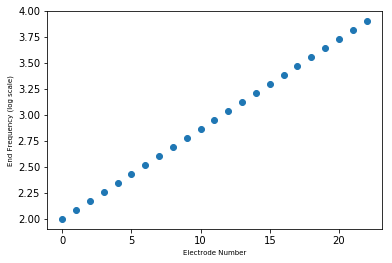

In [3]:
plt.plot(np.log10(ci4), 'o')
plt.xlabel('Electrode Number', fontsize=7)
plt.ylabel('End Frequency (log scale)', fontsize=7)
plt.savefig('elec.pdf')
plt.show()

In [47]:
def getButterworthFilter(ci, f_nyquist,filename):
    a = []
    b = []
    w = []
    h = []

    ci_norm = ci/f_nyquist
    print(ci_norm)
    for i in range(len(ci_norm)-1):
        a.append([])
        b.append([])
        w.append([])
        h.append([])
        lab = "Filter " + str(i+1)
        b[i], a[i] = signal.butter(2, [ci_norm[i],ci_norm[i+1]], 'bandpass')
    #     b[i], a[i] = signal.butter(2, [ci4_norm[i],ci4_norm[i+1]], 'band')
        w[i], h[i] = signal.freqz(b[i], a[i],worN=6000)
        plt.semilogx(w[i]*f_nyquist/np.pi, 20 * np.log10(abs(h[i])), label=lab)

    plt.xscale('log')
#     plt.ylim(-4,0)
#     plt.xlim(7500,9500)
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.legend()
    plt.grid(which='both', axis='both')
    # plt.axvline(100, color='green') # cutoff frequency
    plt.savefig(filename)
    plt.show()
    return b,a

[ 0.00453515  0.00653405  0.00941398  0.01356325  0.01954136  0.02815435
  0.04056359  0.05844229  0.08420116  0.12131343  0.17478322  0.2518202
  0.36281179]


/home/nikita/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


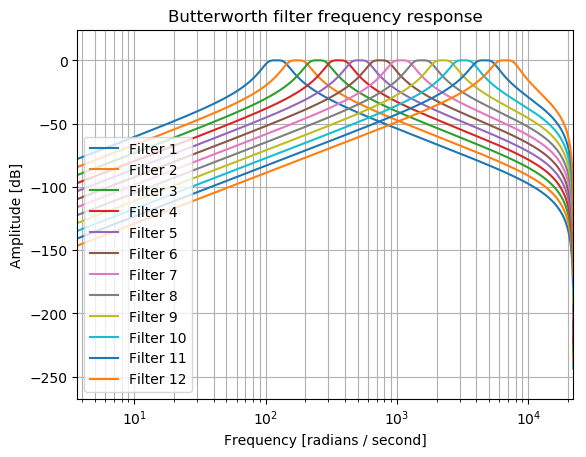

In [48]:
b12, a12 = getButterworthFilter(ci3,44100/2,'12_butterworth.pdf')
# b22, a22 = getButterworthFilter(ci4,8000,'22_butterworth.pdf')
# b3, a3 = getButterworthFilter(ci1,8000,'3_butterworth.pdf')

In [49]:
def PlotChannels(channels, n, fs, filename):
    plt.rc('font', size=3)
    plt.rc('figure', titlesize=5)
    plt.rc('xtick', labelsize=5)
    plt.rc('ytick', labelsize=5)
    t = np.linspace(0, n/fs, n)
    for i in range(1,len(channels)+1):
        lab = "Signal Channel " + str(i)
        ax = plt.subplot(6,2,i)
        ax.plot(t,channels[i-1]*10**5, label=lab)
        ax.set_title(lab, color='red')
        ax.set_xlabel('Seconds')
        ax.set_ylabel('Amplitude ($10^{5}$)')
        ax.set_xticks(np.arange(0,n/fs),(n/fs)/10)
        ax.grid(True)
    plt.subplots_adjust(wspace=0.5, hspace=2.5)
    plt.savefig(filename, dpi=300)
    plt.show()

In [54]:
def Sound(file,b,a,N):
    plt.rcParams.update(plt.rcParamsDefault)
    fs, data = wavfile.read(file+'.wav')
    n = len(data)
    t = np.linspace(0, n/fs, n)
    plt.plot(t,(data))
    plt.xlabel('Seconds (s)')
    plt.ylabel('Amplitude')
#     plt.xlim(1,1.02)
#     plt.xticks(np.arange(0,n/fs),(n/fs)/10)
    plt.grid(True)
    plt.savefig(file+"_signal.pdf", dpi=300)
    plt.show()
    nfft = int(fs*10/1000)
    no = int(nfft)
    Pxx, freqs, bins, im = plt.specgram(data, NFFT=nfft, Fs=fs, noverlap=no)
    plt.xlabel('t (s)')
    plt.ylabel('Frequency (Hz)')
    cbar = plt.colorbar(im)
    cbar.set_label('Amplitude')
    
    plt.savefig(file+'_original.pdf')
    plt.show()
    channels = []
    joint_signal = 0
    
    for i in range(0,N-1):
        channels.append([])
        channels[i] = signal.filtfilt(b[i], a[i], data)
        joint_signal = joint_signal + channels[i]
        
    PlotChannels(channels, n, fs, file+'_channels.pdf')
    plt.rcParams.update(plt.rcParamsDefault)
    plt.magnitude_spectrum(data, Fs=fs, scale='dB', color='C1')
    plt.savefig(file+'_spectrum.pdf')
    plt.show()
#     plt.figure(figsize=(10, 10), dpi=100)
    Pxx, freqs, bins, im = plt.specgram(joint_signal, NFFT=441, Fs=fs, noverlap=220)
    plt.xlabel('t (s)')
    plt.ylabel('Frequency (Hz)')
    cbar = plt.colorbar(im)
    cbar.set_label('Amplitude')
    plt.savefig(file+'_joint.pdf')
    plt.show()
    
    return channels, joint_signal, data
    

/home/nikita/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


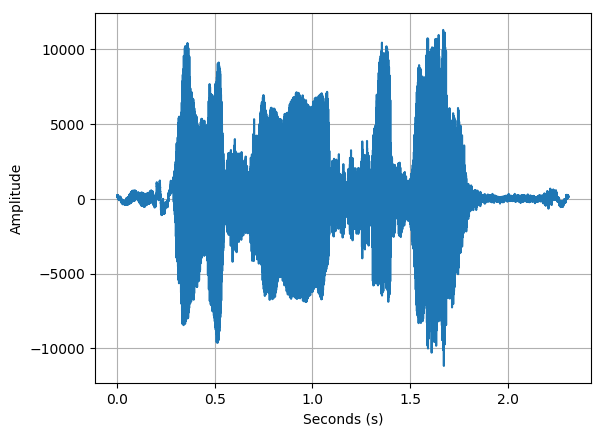

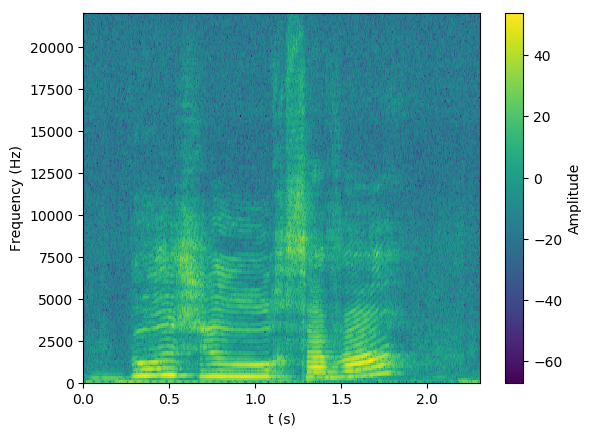

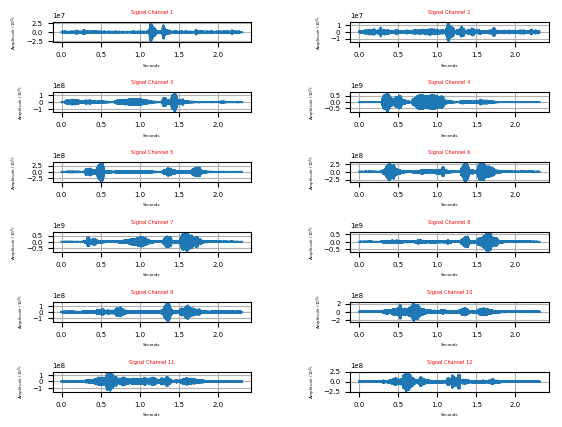

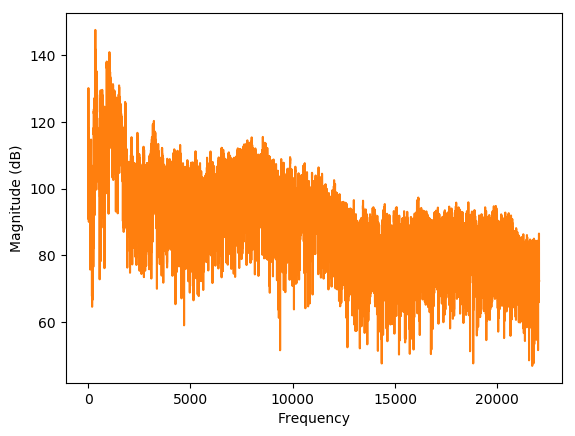

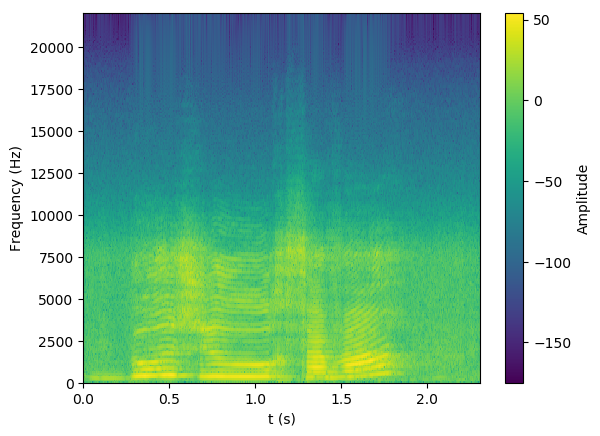

In [51]:
jc, js, jd = Sound('Joycelyne', b12, a12, N3)


In [352]:
sd.play(js)
min(js)

-0.0067636599879163867

/home/nikita/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


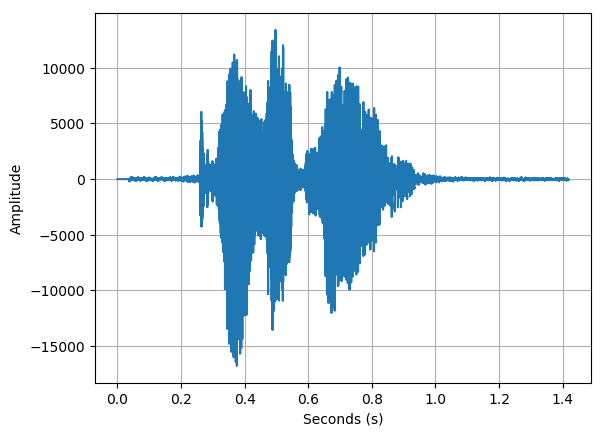

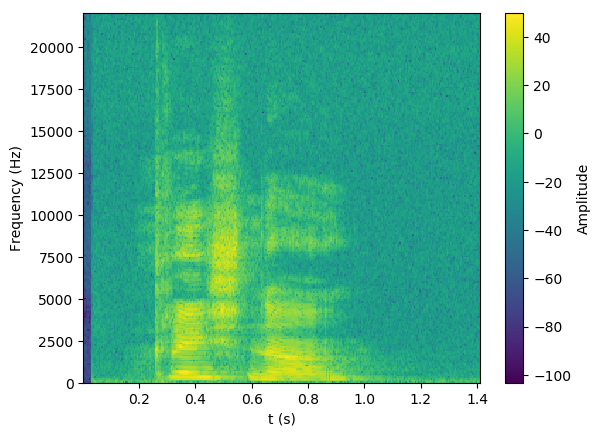

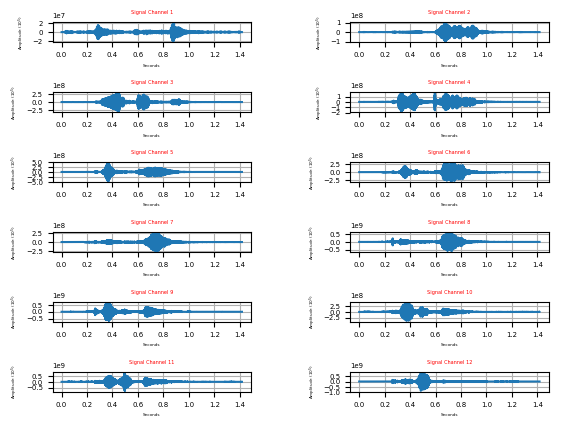

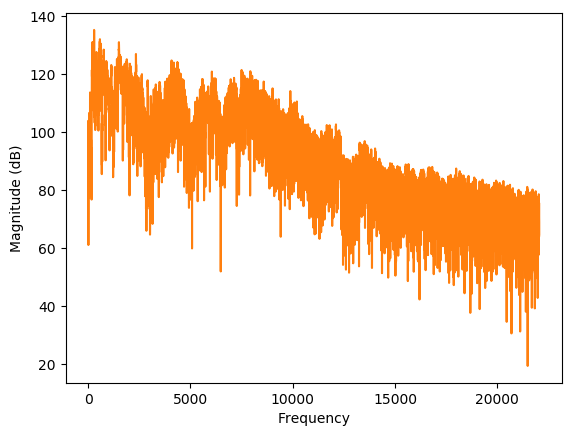

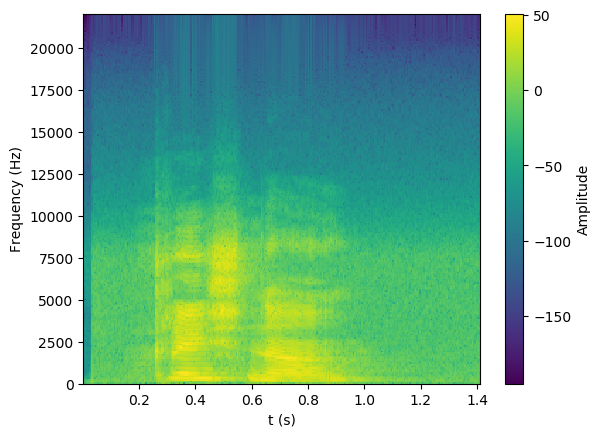

([array([-0.58863707, -0.60160564, -0.61448124, ..., -0.00100139,
         -0.00084563, -0.0007057 ]),
  array([-0.03823218, -0.03147023, -0.02471614, ..., -0.00394291,
         -0.00336867, -0.00284291]),
  array([ 0.14518586,  0.15243794,  0.15947758, ..., -0.02807035,
         -0.0238057 , -0.01994305]),
  array([ 0.17872588,  0.18755146,  0.19583877, ..., -0.07007297,
         -0.0587243 , -0.0485883 ]),
  array([ 0.23173406,  0.23879896,  0.24447702, ...,  0.08876771,
          0.07403977,  0.06095029]),
  array([ 0.248858  ,  0.24583748,  0.2399964 , ..., -0.78736913,
         -0.70759399, -0.62439877]),
  array([ 0.16956265,  0.14262958,  0.11287502, ...,  0.52355106,
          0.55239405,  0.55766486]),
  array([-0.04614459, -0.09230562, -0.13245141, ..., -0.20898734,
         -0.27205861, -0.29787308]),
  array([-0.19689871, -0.17449434, -0.13626287, ..., -2.21066524,
         -1.84240414, -1.32699568]),
  array([ 0.09306862,  0.12110396,  0.12101456, ..., -1.90549986,
       

In [52]:
Sound('Krishna', b12, a12, N3)

/home/nikita/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


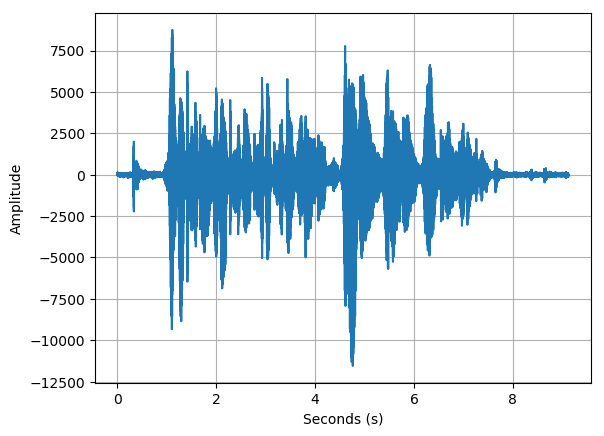

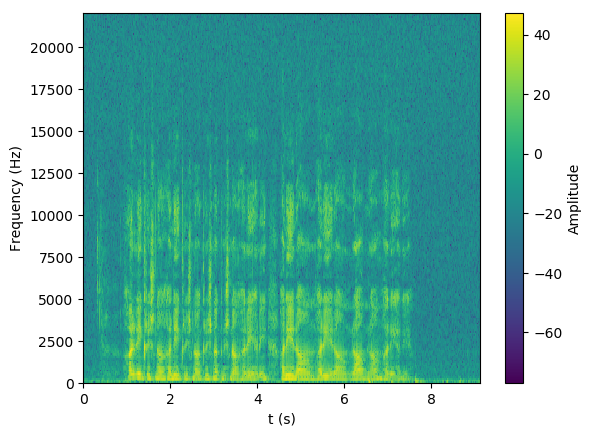

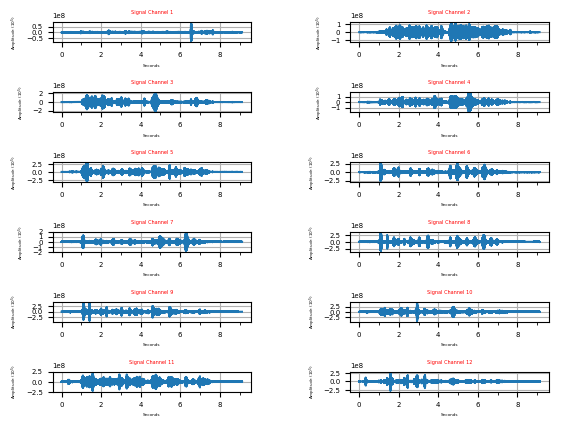

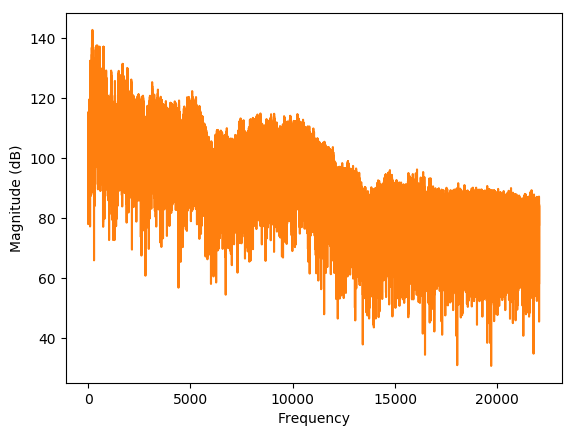

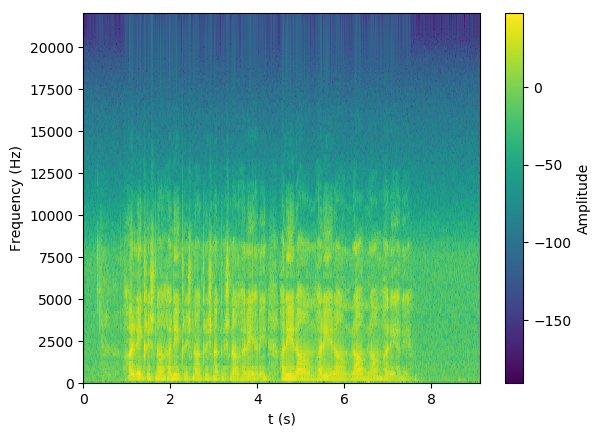

([array([ -5.15623053e+00,  -4.99873191e+00,  -4.83938196e+00, ...,
          -1.14351464e-03,  -9.44560256e-04,  -7.71024770e-04]),
  array([-0.28244209, -0.25179527, -0.22115567, ...,  0.0111326 ,
          0.00943817,  0.00790529]),
  array([-0.73066769, -0.66313883, -0.59454584, ...,  0.02634005,
          0.02217599,  0.0184422 ]),
  array([-0.72459435, -0.75174015, -0.77782648, ...,  0.08153938,
          0.0692747 ,  0.05809377]),
  array([-1.8094729 , -1.93305031, -2.04571739, ..., -0.05307388,
         -0.05110989, -0.0480101 ]),
  array([ 4.81876676,  4.09885023,  3.31401988, ..., -0.06341434,
         -0.03318886, -0.01029648]),
  array([ 5.8461348 ,  6.58244122,  7.19830005, ...,  0.89857948,
          0.89191653,  0.85242518]),
  array([-3.97241354, -4.45136646, -4.72963058, ...,  0.91409894,
          0.52969548,  0.16256462]),
  array([-1.40371954, -1.44927472, -1.3280555 , ...,  3.89066537,
          2.90266606,  1.76269504]),
  array([ 1.02234   ,  0.01327873, -0.96207

In [53]:
Sound('Mahamantra', b12, a12, N3)

/home/nikita/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


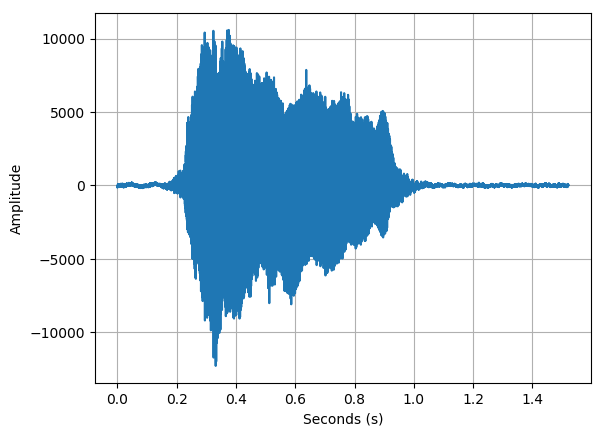

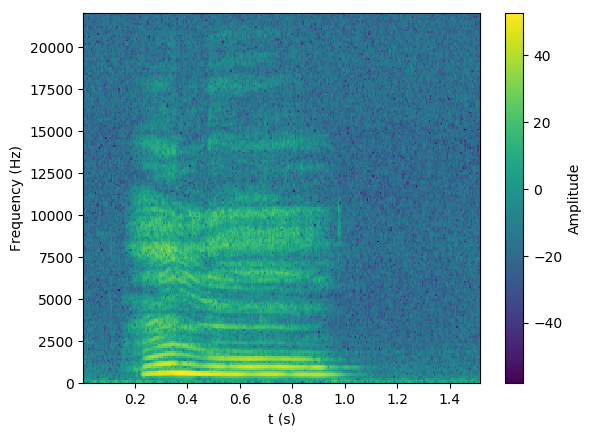

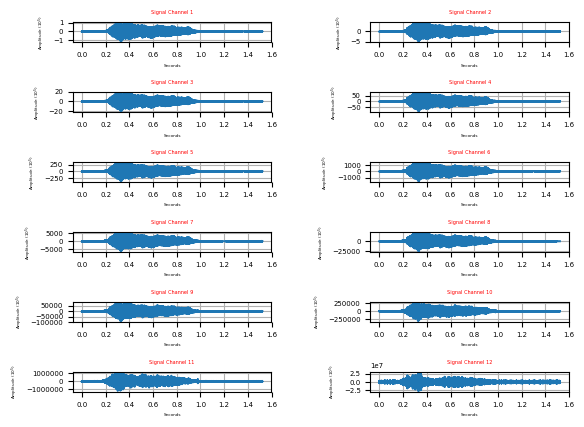

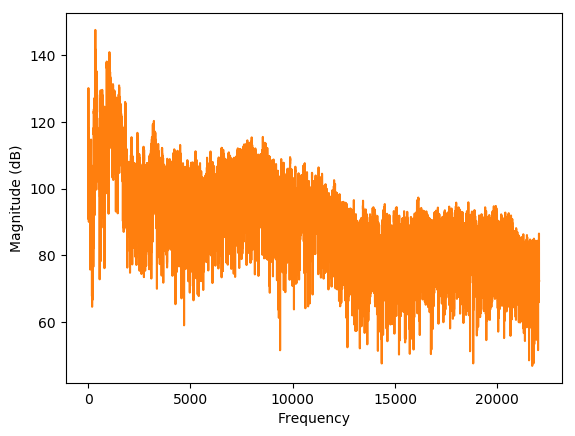

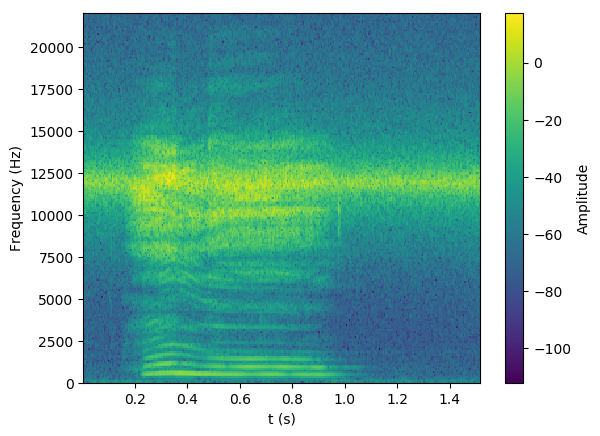

([array([ -7.25055148e-09,   5.54272696e-09,   7.44449651e-09, ...,
           4.38870169e-08,   2.34562039e-08,   1.81263787e-08]),
  array([ -3.09980288e-08,   2.39490910e-08,   3.22391609e-08, ...,
           1.88436443e-07,   1.00090377e-07,   7.74950719e-08]),
  array([ -1.31988644e-07,   1.03778508e-07,   1.40008636e-07, ...,
           8.07712378e-07,   4.25062223e-07,   3.29971609e-07]),
  array([ -5.58375334e-07,   4.52304587e-07,   6.10758503e-07, ...,
           3.45328258e-06,   1.79182087e-06,   1.39593834e-06]),
  array([ -2.33723026e-06,   1.99356629e-06,   2.68270754e-06, ...,
           1.47065138e-05,   7.46482906e-06,   5.84307564e-06]),
  array([ -9.60950297e-06,   8.97165259e-06,   1.18972976e-05, ...,
           6.22641539e-05,   3.05046917e-05,   2.40237574e-05]),
  array([ -3.83075166e-05,   4.18307796e-05,   5.32968085e-05, ...,
           2.61434834e-04,   1.20649407e-04,   9.57687914e-05]),
  array([-0.00014467,  0.00020542,  0.00023873, ...,  0.00108752,
   

In [493]:
Sound('Hello', b12, a12, N3)

/home/nikita/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


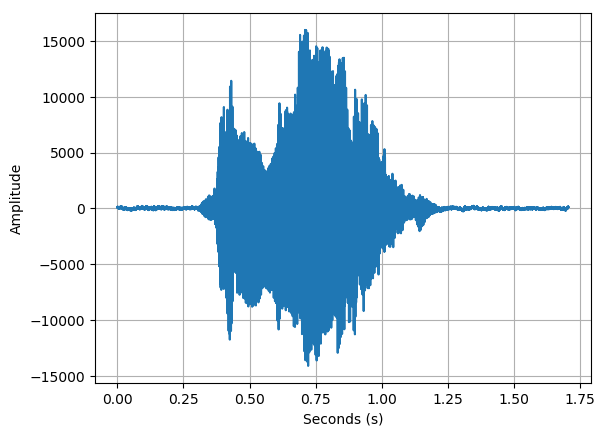

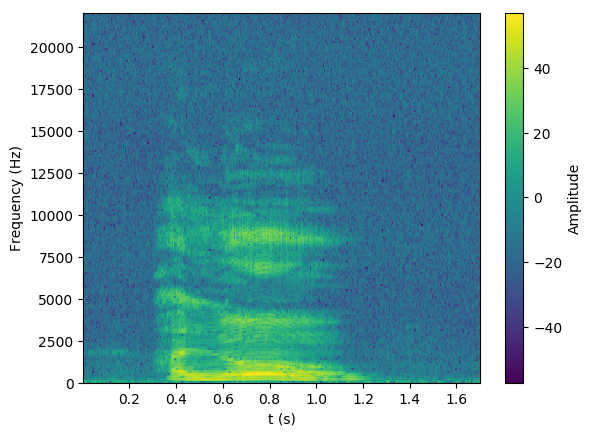

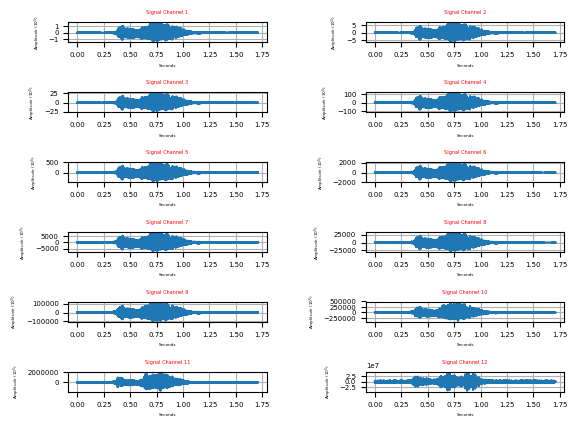

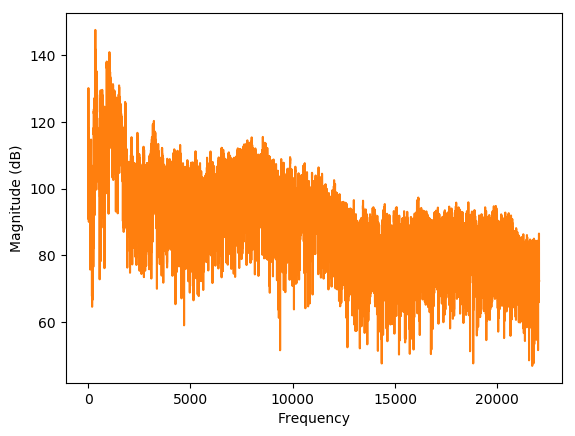

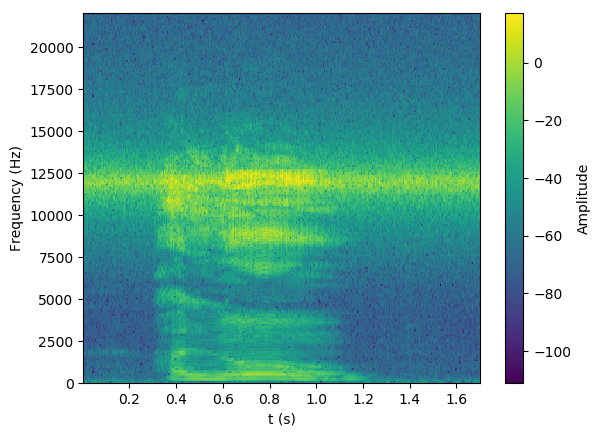

([array([  9.69761261e-08,   9.96298361e-08,   1.09645978e-07, ...,
           1.26521860e-07,   1.03450198e-07,   6.88802391e-08]),
  array([  4.14598635e-07,   4.25796096e-07,   4.68755925e-07, ...,
           5.42074012e-07,   4.42625387e-07,   2.94481273e-07]),
  array([  1.76534811e-06,   1.81199684e-06,   1.99600020e-06, ...,
           2.31588023e-06,   1.88730189e-06,   1.25389212e-06]),
  array([  7.46827009e-06,   7.65817599e-06,   8.44529642e-06, ...,
           9.85017222e-06,   8.00440925e-06,   5.30456567e-06]),
  array([  3.12604547e-05,   3.19990562e-05,   3.53653569e-05, ...,
           4.16005126e-05,   3.36645635e-05,   2.22036874e-05]),
  array([  1.28527102e-04,   1.31112126e-04,   1.45555715e-04, ...,
           1.73692060e-04,   1.39700564e-04,   9.12902783e-05]),
  array([ 0.00051236,  0.00051875,  0.00058157, ...,  0.00071182,
          0.00056743,  0.00036392]),
  array([ 0.00193491,  0.00192114,  0.00220653, ...,  0.00283189,
          0.00222996,  0.00137433

In [494]:
Sound('Helloh', b12, a12, N3)